In [38]:
# system
import warnings
import os

# processing
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# performance 
from sklearn.metrics import make_scorer, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, \
confusion_matrix, classification_report

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

In [75]:
df = pd.read_csv('../artifacts/data.csv')
df1 = df.query('Premium_Level == 1')
df2 = df.query('Premium_Level > 1')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Premium_Level,Premium_Log
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1,3.0,4.606961
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0,3.0,4.525511
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1,3.0,4.583131
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,3.0,4.456654
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,3.0,4.439270


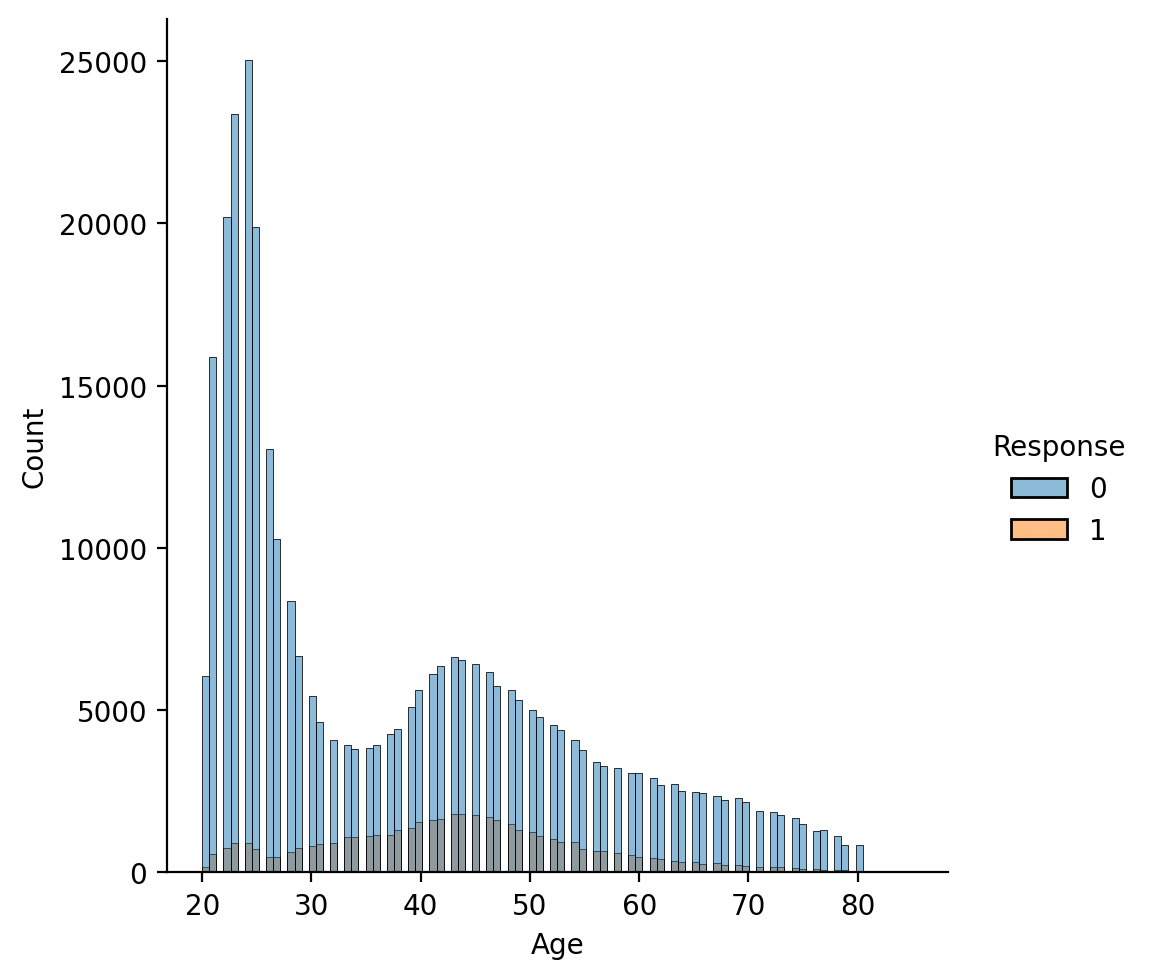

In [77]:
import seaborn as sns
sns.displot(df, x='Age', hue='Response', bins=100);

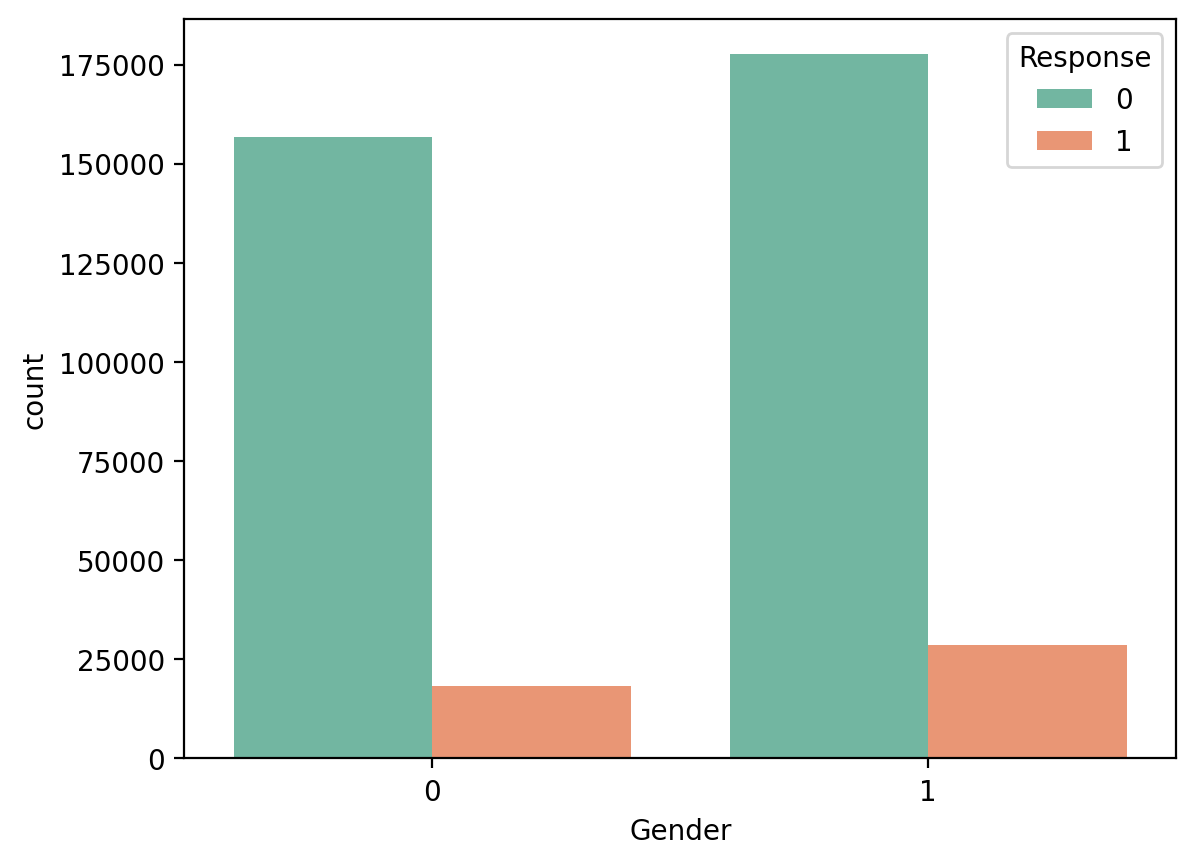

In [85]:
sns.countplot(x="Gender", hue="Response", data=df, palette="Set2");

In [3]:
print('df1', df1['Response'].value_counts(normalize=True))
print('df2', df2['Response'].value_counts(normalize=True))

df1 Response
0    0.868906
1    0.131094
Name: proportion, dtype: float64
df2 Response
0    0.879187
1    0.120813
Name: proportion, dtype: float64


In [4]:
print('df1: \n', df1.groupby(['Previously_Insured'])['Response'].value_counts(normalize=True))

print('df2: \n', df2.groupby(['Previously_Insured'])['Response'].value_counts(normalize=True))

df1: 
 Previously_Insured  Response
0                   0           0.795459
                    1           0.204541
1                   0           0.998466
                    1           0.001534
Name: proportion, dtype: float64
df2: 
 Previously_Insured  Response
0                   0           0.769300
                    1           0.230700
1                   0           0.999193
                    1           0.000807
Name: proportion, dtype: float64


There is no specific need to keep the premium level 1 seperate.

In [5]:
df.nunique().sort_values()

Gender                       2
Driving_License              2
Previously_Insured           2
Vehicle_Damage               2
Response                     2
Vehicle_Age                  3
Premium_Level                5
Region_Code                 53
Age                         66
Policy_Sales_Channel       155
Vintage                    290
Annual_Premium           48838
Premium_Log              48838
id                      381109
dtype: int64

In [6]:
df.drop(['Premium_Log', 'id'], axis=1, inplace=True)

Given the imbalance nature of data on target variable (response), accuracy_score is not an optimal metric to track model performance.

The client is trying to cross selling vehical insurance and only 12% response rate, it is best to maximize true positive (1) response ~ don't miss positive response ~ minimize false negative.


In previous attempts, the model performance for positive response has remain low. Following things can be done to improve positive response prediction:

- scaling predictors: minmax or robust would work
- trying prediction probability threshold: we need to reduce threshold to get more positive response in predicition.

since we also have to check with different thresholds, we should use threshold independent parameter.

# Data rescaling

In [7]:
# rs = RobustScaler()
# df[df.columns.drop('Response', 'id')] = rs.fit_transform(df.drop('Response', axis=1))

mm = MinMaxScaler() 
cols_to_scale = df.columns.drop(['Response'])
df[cols_to_scale] = mm.fit_transform(df[cols_to_scale])

Xtrain, Xtest, ytrain, ytest = train_test_split(df[cols_to_scale], df['Response'], random_state=42, test_size=0.2, stratify=df['Response'])

In [8]:
Xtrain.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Premium_Level'],
      dtype='object')

In [9]:
Xtrain.nunique().sort_values()

Gender                      2
Driving_License             2
Previously_Insured          2
Vehicle_Damage              2
Vehicle_Age                 3
Premium_Level               5
Region_Code                53
Age                        66
Policy_Sales_Channel      154
Vintage                   290
Annual_Premium          46479
dtype: int64

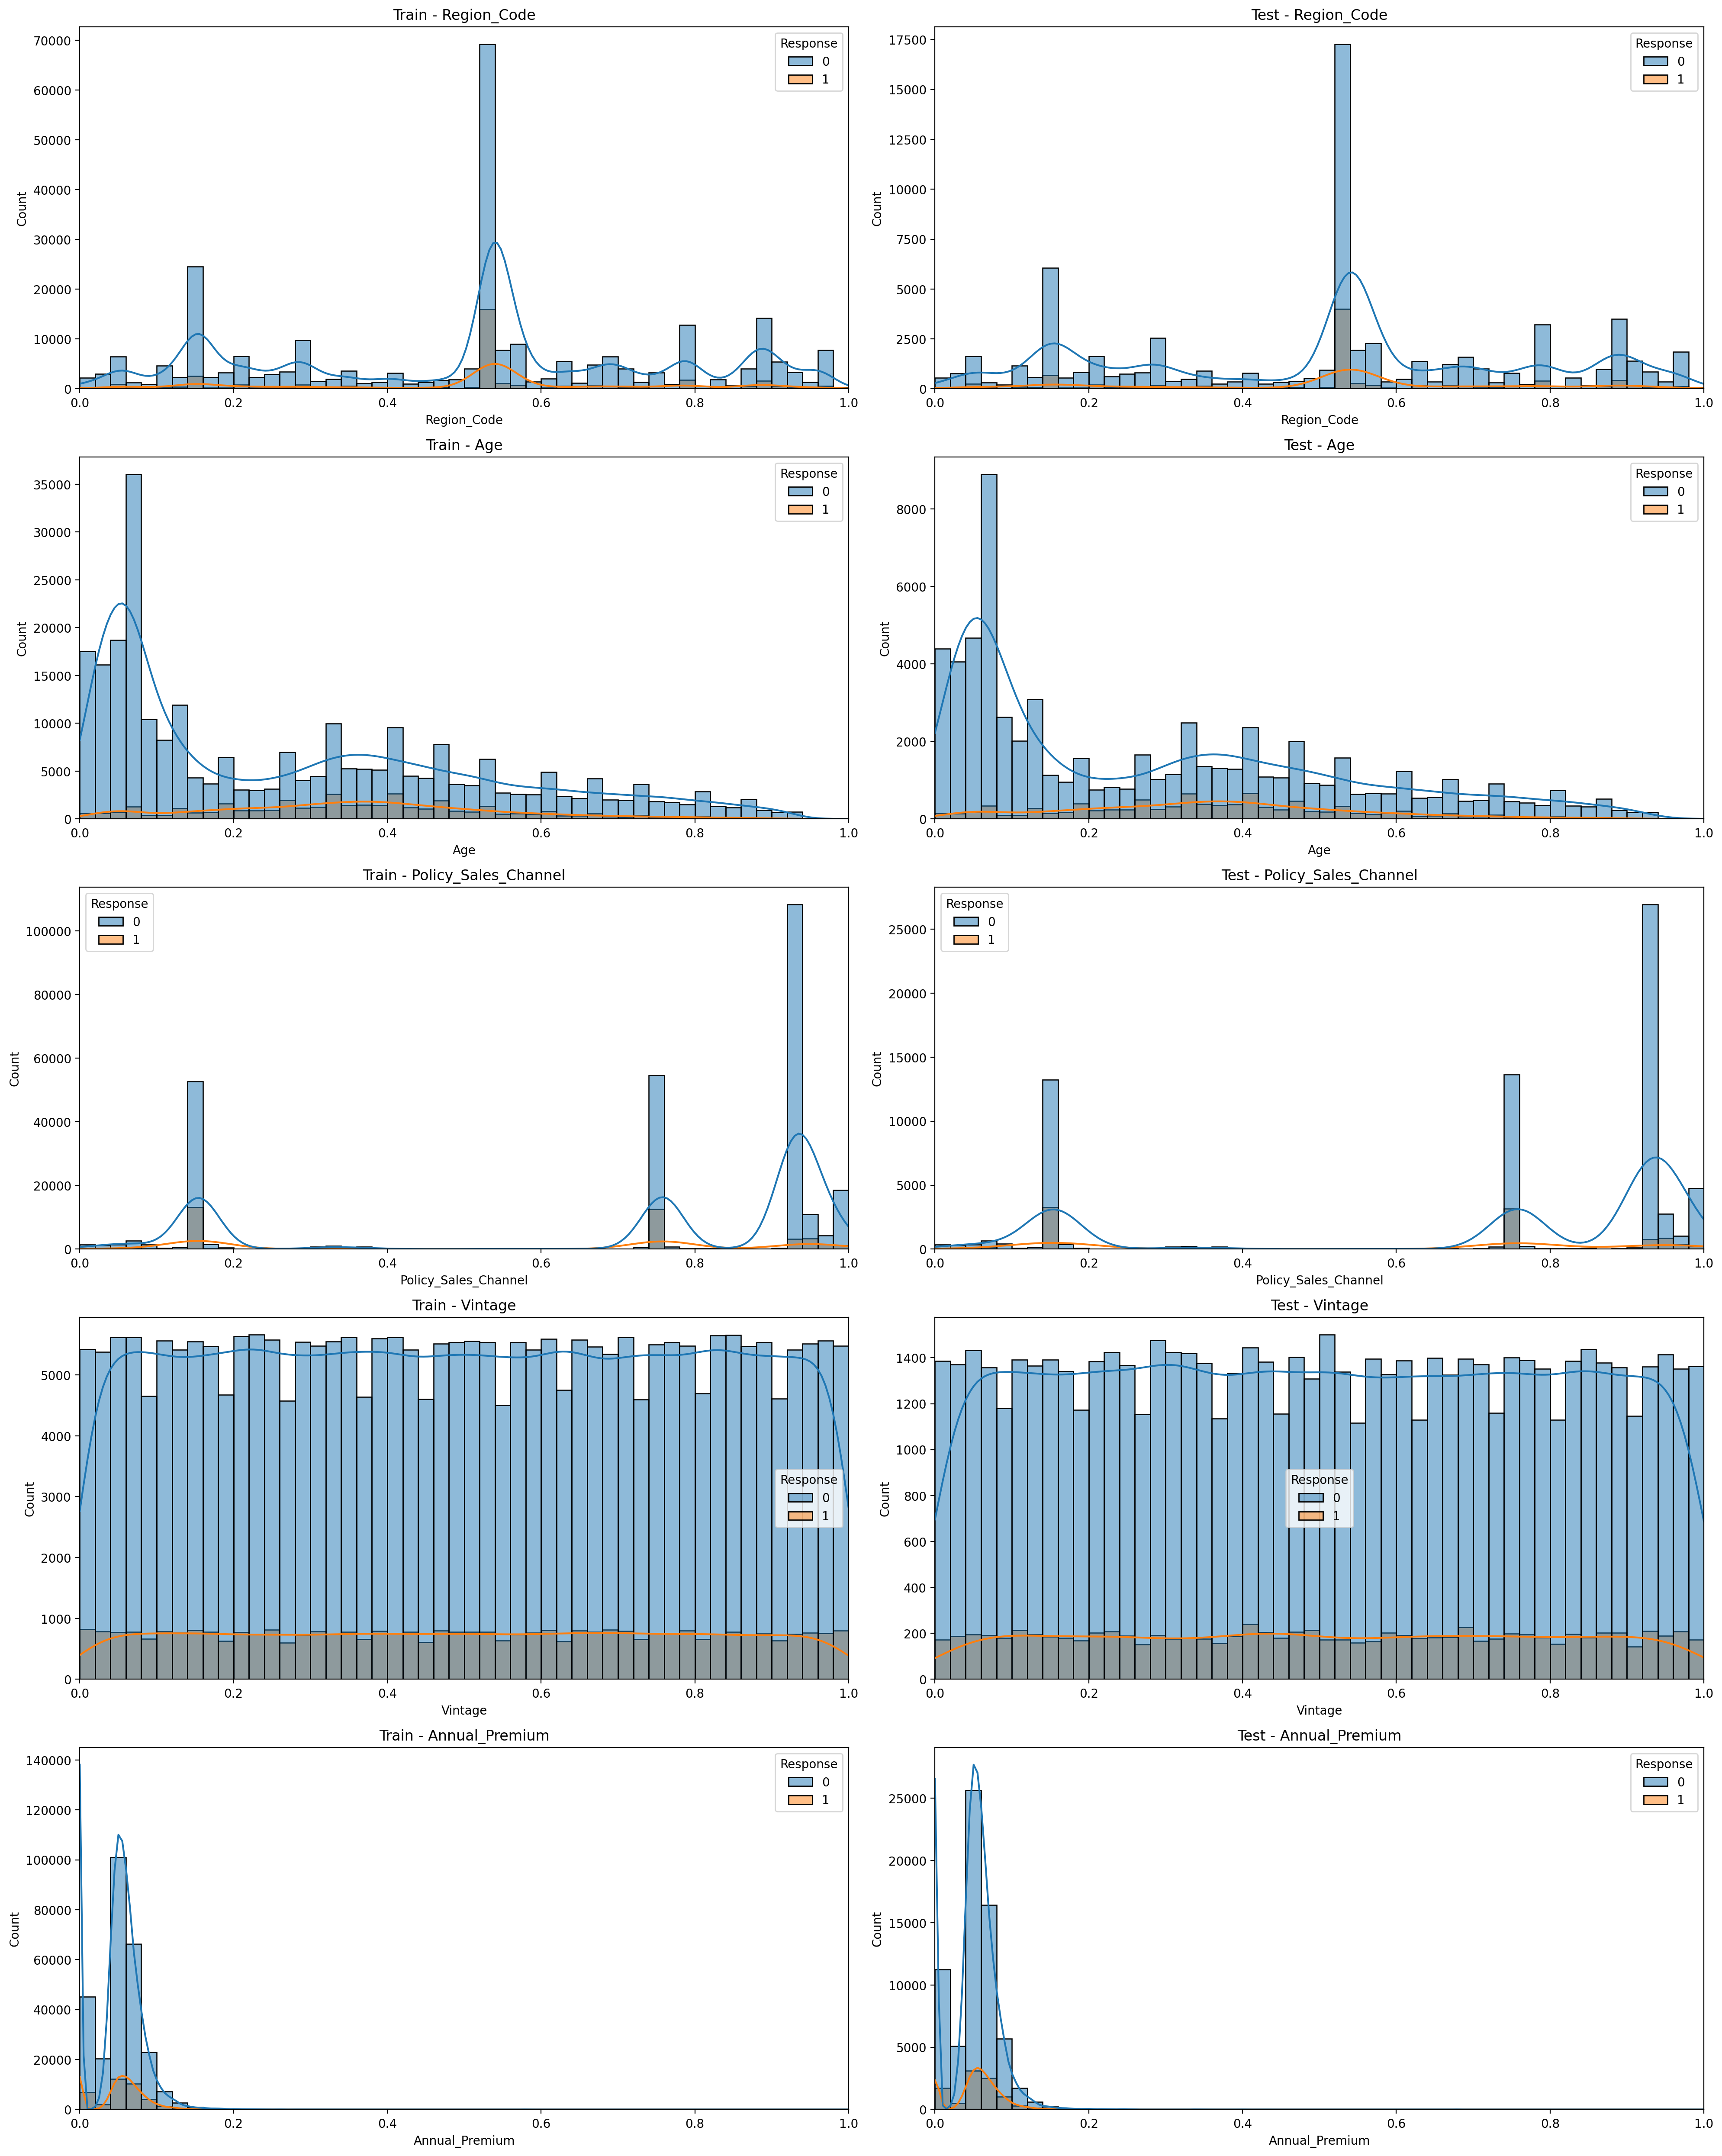

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cat = ['Region_Code', 'Age', 'Policy_Sales_Channel', 'Vintage', 'Annual_Premium']

fig, ax = plt.subplots(len(cat), 2, figsize=(20, 25))
for i, var in enumerate(cat):
    sns.histplot(x=Xtrain[var], hue=ytrain, ax=ax[i, 0], bins=50, common_bins=True, kde=True) # left
    ax[i, 0].set_xlim(Xtrain[var].min(), Xtrain[var].max())
    ax[i, 0].set_title(f"Train - {var}")

    sns.histplot(x=Xtest[var], hue=ytest, ax=ax[i, 1], bins=50, common_bins=True, kde=True) # right
    ax[i, 1].set_xlim(Xtest[var].min(), Xtest[var].max())
    ax[i, 1].set_title(f"Test - {var}")
    
plt.tight_layout()  # prevent overlap
plt.show()

In [11]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(Xtrain, ytrain)
print(classification_report(ytest, dtc.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     66880
           1       0.29      0.30      0.29      9342

    accuracy                           0.82     76222
   macro avg       0.60      0.60      0.60     76222
weighted avg       0.83      0.82      0.83     76222



In [12]:
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtc.fit(Xtrain, ytrain)
print(classification_report(ytest, dtc.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     66880
           1       0.29      0.27      0.28      9342

    accuracy                           0.83     76222
   macro avg       0.59      0.59      0.59     76222
weighted avg       0.82      0.83      0.83     76222



As the model is not improving, the issue lies in the data imbalance. The model is unable to perform on well on the minority class. 
apart from threshold handling, we can try model with class weighting and resampling. 

# class weighting

In [21]:
xgb_default = XGBClassifier(random_state=42)
xgb_default.fit(Xtrain, ytrain)
print(classification_report(ytrain, xgb_default.predict(Xtrain)))
print(classification_report(ytest, xgb_default.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94    267519
           1       0.70      0.05      0.09     37368

    accuracy                           0.88    304887
   macro avg       0.79      0.52      0.51    304887
weighted avg       0.86      0.88      0.83    304887

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.42      0.03      0.05      9342

    accuracy                           0.88     76222
   macro avg       0.65      0.51      0.49     76222
weighted avg       0.82      0.88      0.83     76222



In [13]:
xgb = XGBClassifier(scale_pos_weight = 88/12, random_state=42)
xgb.fit(Xtrain, ytrain)
print(classification_report(ytest, xgb.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81     66880
           1       0.29      0.90      0.44      9342

    accuracy                           0.72     76222
   macro avg       0.63      0.80      0.62     76222
weighted avg       0.90      0.72      0.76     76222



In [14]:
print(confusion_matrix(ytest, xgb.predict(Xtest)))

[[46063 20817]
 [  888  8454]]


In [22]:
print(confusion_matrix(ytest, dtc.predict(Xtest)))

[[60643  6237]
 [ 6789  2553]]


# resampling

In [15]:
ytrain.value_counts()

Response
0    267519
1     37368
Name: count, dtype: int64

response 1 has 37_368 record, undersampling would result in around 2*37_368 records which is sufficient for modeling.

In [16]:
from sklearn.utils import resample

train_majority = Xtrain[ytrain == 0]
train_minority = Xtrain[ytrain == 1]

train_majority_downsampled = resample(train_majority, 
                                      replace=False,    
                                      n_samples=len(train_minority),  
                                      random_state=42)  

Xtrain_under = pd.concat([train_majority_downsampled, train_minority])
ytrain_under = pd.concat([ytrain[train_majority_downsampled.index], ytrain[train_minority.index]])

print(ytrain_under.value_counts())

Response
0    37368
1    37368
Name: count, dtype: int64


In [17]:
dtc_resample = DecisionTreeClassifier(random_state=42)
dtc_resample.fit(Xtrain_under, ytrain_under)
print(classification_report(ytest, dtc_resample.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     66880
           1       0.26      0.71      0.38      9342

    accuracy                           0.72     76222
   macro avg       0.60      0.72      0.60     76222
weighted avg       0.86      0.72      0.77     76222



In [18]:
print(classification_report(ytrain_under, dtc_resample.predict(Xtrain_under)))
print(classification_report(ytrain, dtc_resample.predict(Xtrain)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37368
           1       1.00      1.00      1.00     37368

    accuracy                           1.00     74736
   macro avg       1.00      1.00      1.00     74736
weighted avg       1.00      1.00      1.00     74736

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    267519
           1       0.37      1.00      0.54     37368

    accuracy                           0.79    304887
   macro avg       0.68      0.88      0.70    304887
weighted avg       0.92      0.79      0.83    304887



In [19]:
print(classification_report(ytrain, dtc.predict(Xtrain)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267519
           1       1.00      1.00      1.00     37368

    accuracy                           1.00    304887
   macro avg       1.00      1.00      1.00    304887
weighted avg       1.00      1.00      1.00    304887



In [20]:
print(classification_report(ytrain, xgb.predict(Xtrain)))

              precision    recall  f1-score   support

           0       0.99      0.69      0.82    267519
           1       0.30      0.95      0.46     37368

    accuracy                           0.72    304887
   macro avg       0.65      0.82      0.64    304887
weighted avg       0.90      0.72      0.77    304887



we are observing overfitting, even on the model before undersampling other than xgb.

In [23]:
dt_params = {}

dt_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
             param_grid=dt_params,
             scoring='roc_auc', cv=3, verbose=2)

dt_search.fit(Xtrain, ytrain)
print('dtc default param roc_auc score:', dt_search.best_score_)
dt_search = dt_search.best_estimator_

print(classification_report(ytrain, dt_search.predict(Xtrain)))
print(classification_report(ytest, dt_search.predict(Xtest)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.7s
dtc default param roc_auc score: 0.6021993897273181
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267519
           1       1.00      1.00      1.00     37368

    accuracy                           1.00    304887
   macro avg       1.00      1.00      1.00    304887
weighted avg       1.00      1.00      1.00    304887

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     66880
           1       0.29      0.30      0.29      9342

    accuracy                           0.82     76222
   macro avg       0.60      0.60      0.60     76222
weighted avg       0.83      0.82      0.83    

In [24]:
dt_params = {
    "max_depth": [5, 10, 12, 14],  
    "min_samples_split": [50, 100, 150],  
    "min_samples_leaf": [5, 10, 20],  
    "class_weight": ["balanced"]
}

from sklearn.model_selection import StratifiedKFold

dt_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
             param_grid=dt_params,
             cv=StratifiedKFold(n_splits=3), 
             scoring='roc_auc', 
             verbose=2)

dt_search.fit(Xtrain, ytrain)
print(dt_search.best_score_)

dt_best = dt_search.best_estimator_

print(classification_report(ytrain, dt_best.predict(Xtrain)))
print(classification_report(ytest, dt_best.predict(Xtest)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=50; total time=   1.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=50; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=50; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=150; total time=   1.3s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=150; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=15

In [25]:
dt_search.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 20,
 'min_samples_split': 150}

In [26]:
print(confusion_matrix(ytest, dt_best.predict(Xtest)))

[[44569 22311]
 [  686  8656]]


In [ ]:
xgb_grids = {}

xgb_search = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1), 
             param_grid=xgb_grids,
             cv=StratifiedKFold(3),
             scoring='roc_auc',
             verbose=2, n_jobs=-1
             )

xgb_search.fit(Xtrain, ytrain)
xgb_search.best_score_

print('xgb default param roc_auc score:',xgb_search.best_score_)

xgb_roc = xgb_search.best_estimator_

print('training report: \n', classification_report(ytrain, xgb_roc.predict(Xtrain)))
print('testing report: \n', classification_report(ytest, xgb_roc.predict(Xtest)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
xgb default param roc_auc score: 0.8542726263132331
training report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    267519
           1       0.70      0.05      0.09     37368

    accuracy                           0.88    304887
   macro avg       0.79      0.52      0.51    304887
weighted avg       0.86      0.88      0.83    304887

testing report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.42      0.03      0.05      9342

    accuracy                           0.88     76222
   macro avg       0.65      0.51      0.49     76222
weighted avg       0.82      0.88      0.83     76222



In [35]:
print('roc:', roc_auc_score(ytest, xgb.predict(Xtest)))
confusion_matrix(ytest, xgb.predict(Xtest))

roc: 0.7968432182718576


array([[46063, 20817],
       [  888,  8454]], dtype=int64)

In [31]:
confusion_matrix(ytest, xgb_roc.predict(Xtest))

array([[66562,   318],
       [ 9107,   235]], dtype=int64)

In [43]:
xgb_grids = {}

xgb_search = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1), 
             param_grid=xgb_grids,
             cv=StratifiedKFold(3),
             scoring='average_precision',
             verbose=2, n_jobs=-1
             )

xgb_search.fit(Xtrain, ytrain)
xgb_search.best_score_

print('xgb default param pr score:',xgb_search.best_score_)

xgb_pr = xgb_search.best_estimator_
print('xgb default param roc score:', roc_auc_score(ytest, xgb_pr.predict_proba(Xtest)[:, 1]))

print('training report: \n', classification_report(ytrain, xgb_pr.predict(Xtrain)))
print('testing report: \n', classification_report(ytest, xgb_pr.predict(Xtest)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
xgb default param pr score: 0.36199261368158253
xgb default param roc score: 0.856323134626869
training report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    267519
           1       0.70      0.05      0.09     37368

    accuracy                           0.88    304887
   macro avg       0.79      0.52      0.51    304887
weighted avg       0.86      0.88      0.83    304887

testing report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.42      0.03      0.05      9342

    accuracy                           0.88     76222
   macro avg       0.65      0.51      0.49     76222
weighted avg       0.82      0.88      0.83     76222



In [55]:
xgb_grids = {
    'learning_rate': [0.1, 0.15], 
    'max_depth': [2, 3, 4],  
    'n_estimators': [300, 400], 
    'scale_pos_weight': [2, 4, 5] 
}

xgb_search = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1), 
             param_grid=xgb_grids,
             cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
             scoring='roc_auc', verbose=2, n_jobs=-1
             )

xgb_search.fit(Xtrain, ytrain)
xgb_search.best_score_

print('xgb default param roc_auc score:',xgb_search.best_score_)

xgb_temp = xgb_search.best_estimator_

print('training report: \n', classification_report(ytrain, xgb_temp.predict(Xtrain)))
print('testing report: \n', classification_report(ytest, xgb_temp.predict(Xtest)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
xgb default param roc_auc score: 0.8579623853354573
training report: 
               precision    recall  f1-score   support

           0       0.98      0.72      0.83    267519
           1       0.31      0.87      0.45     37368

    accuracy                           0.74    304887
   macro avg       0.64      0.80      0.64    304887
weighted avg       0.89      0.74      0.78    304887

testing report: 
               precision    recall  f1-score   support

           0       0.98      0.72      0.83     66880
           1       0.31      0.87      0.45      9342

    accuracy                           0.74     76222
   macro avg       0.64      0.80      0.64     76222
weighted avg       0.89      0.74      0.78     76222



In [57]:
xgb_grids = {
    'learning_rate': [0.1, 0.12], 
    'max_depth': [2, 3, 4],  
    'n_estimators': [400, 500], 
    'scale_pos_weight': [2, 4, 5] 
}

xgb_search = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1), 
             param_grid=xgb_grids,
             cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
             scoring='average_precision', verbose=2, n_jobs=-1
             )

xgb_search.fit(Xtrain, ytrain)
xgb_search.best_score_

print('xgb default param pc score:',xgb_search.best_score_)
print('xgb default param roc score:', roc_auc_score(ytest, xgb_pr.predict_proba(Xtest)[:, 1]))

xgb_temp = xgb_search.best_estimator_

print('training report: \n', classification_report(ytrain, xgb_temp.predict(Xtrain)))
print('testing report: \n', classification_report(ytest, xgb_temp.predict(Xtest)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
xgb default param pc score: 0.37176034580601697
xgb default param roc score: 0.856323134626869
training report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92    267519
           1       0.40      0.39      0.40     37368

    accuracy                           0.85    304887
   macro avg       0.66      0.66      0.66    304887
weighted avg       0.85      0.85      0.85    304887

testing report: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     66880
           1       0.39      0.38      0.38      9342

    accuracy                           0.85     76222
   macro avg       0.65      0.65      0.65     76222
weighted avg       0.85      0.85      0.85     76222



# Improving model performance

Model performance is stuck around 0.85 roc_auc_score. attempting feature engineering to further improve the performance.

In [67]:
pd.DataFrame({'feature': xgb_temp.feature_names_in_,
              'imp_value': xgb_temp.feature_importances_}).sort_values(by='imp_value',
                                                                       ascending=False)

,feature,imp_value
4,Previously_Insured,0.526189
6,Vehicle_Damage,0.421430
1,Age,0.021847
5,Vehicle_Age,0.008132
8,Policy_Sales_Channel,0.006772
10,Premium_Level,0.004219
3,Region_Code,0.003648
2,Driving_License,0.002810
0,Gender,0.002202
7,Annual_Premium,0.001610


In [69]:
Xtrain.corr()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Premium_Level
Gender,1.000000,0.146287,-0.017574,0.000442,-0.082111,0.160242,0.092104,0.002495,-0.111001,-0.003261,-0.023551
Age,0.146287,1.000000,-0.079493,0.042210,-0.255307,0.766259,0.268692,0.068549,-0.578342,-0.002953,-0.042716
Driving_License,-0.017574,-0.079493,1.000000,-0.000433,0.014743,-0.037754,-0.017122,-0.012078,0.044602,-0.001232,-0.003964
Region_Code,0.000442,0.042210,-0.000433,1.000000,-0.025674,0.043804,0.028633,-0.010764,-0.042069,-0.002801,-0.000047
Previously_Insured,-0.082111,-0.255307,0.014743,-0.025674,1.000000,-0.380799,-0.824721,0.004524,0.220456,0.004212,0.078463
Vehicle_Age,0.160242,0.766259,-0.037754,0.043804,-0.380799,1.000000,0.397581,0.041955,-0.550285,-0.003029,-0.072403
Vehicle_Damage,0.092104,0.268692,-0.017122,0.028633,-0.824721,0.397581,1.000000,0.008662,-0.225974,-0.003159,-0.063734
Annual_Premium,0.002495,0.068549,-0.012078,-0.010764,0.004524,0.041955,0.008662,1.000000,-0.112381,-0.000915,0.821244
Policy_Sales_Channel,-0.111001,-0.578342,0.044602,-0.042069,0.220456,-0.550285,-0.225974,-0.112381,1.000000,0.000830,-0.029213
Vintage,-0.003261,-0.002953,-0.001232,-0.002801,0.004212,-0.003029,-0.003159,-0.000915,0.000830,1.000000,-0.002364


### drop low importance 

In [92]:
xgb_grids = {
    'learning_rate': [0.1, 0.15], 
    'max_depth': [2, 3, 4],  
    'n_estimators': [300, 400], 
    'scale_pos_weight': [2, 4, 5] 
}

xgb_search = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1), 
             param_grid=xgb_grids,
             cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
             scoring='roc_auc', verbose=2, n_jobs=-1
             )

xgb_search.fit(Xtrain.drop(columns=['Premium_Level']), ytrain)
xgb_search.best_score_

print('xgb default param roc_auc score:',xgb_search.best_score_)

xgb_temp = xgb_search.best_estimator_

print('training report: \n', classification_report(ytrain, xgb_temp.predict(Xtrain.drop(columns=['Premium_Level']))))
print('testing report: \n', classification_report(ytest, xgb_temp.predict(Xtest.drop(columns=['Premium_Level']))))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
xgb default param roc_auc score: 0.8580042628644629
training report: 
               precision    recall  f1-score   support

           0       0.97      0.76      0.85    267519
           1       0.32      0.82      0.46     37368

    accuracy                           0.77    304887
   macro avg       0.64      0.79      0.66    304887
weighted avg       0.89      0.77      0.80    304887

testing report: 
               precision    recall  f1-score   support

           0       0.97      0.76      0.85     66880
           1       0.32      0.81      0.46      9342

    accuracy                           0.77     76222
   macro avg       0.64      0.79      0.66     76222
weighted avg       0.89      0.77      0.80     76222



slight improvement by droping feature

### feature engineering

In [94]:
channel_response_rate = df.groupby('Policy_Sales_Channel')['Response'].mean()
df['Policy_Sales_Channel_Enc'] = df['Policy_Sales_Channel'].map(channel_response_rate)

In [95]:
df['Policy_Sales_Channel_Enc']

0         0.199385
1         0.199385
2         0.199385
3         0.028624
4         0.028624
            ...   
381104    0.199385
381105    0.028624
381106    0.021810
381107    0.189148
381108    0.199385
Name: Policy_Sales_Channel_Enc, Length: 381109, dtype: float64

In [90]:
Xtrain['Vehicle_Damage'].describe()

count    304887.000000
mean          0.504971
std           0.499976
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Vehicle_Damage, dtype: float64

In [91]:
(df['Previously_Insured'] - df['Vehicle_Damage']).describe()

count    381109.000000
mean         -0.046666
std           0.953332
min          -1.000000
25%          -1.000000
50%           0.000000
75%           1.000000
max           1.000000
dtype: float64

In [97]:
Xtrain.nunique().sort_values()

Gender                      2
Driving_License             2
Previously_Insured          2
Vehicle_Damage              2
Vehicle_Age                 3
Premium_Level               5
Region_Code                53
Age                        66
Policy_Sales_Channel      154
Vintage                   290
Annual_Premium          46479
dtype: int64

In [98]:
from category_encoders import TargetEncoder

encoder = TargetEncoder()
Xtrain['encoded_policy_channel'] = encoder.fit_transform(Xtrain['encoded_policy_channel'], ytrain)
Xtest['encoded_Region_Code'] = encoder.transform(Xtest['encoded_Region_Code'])

ModuleNotFoundError: No module named 'category_encoders'